# ATLeS - Descriptive Statistics

This script is designed to provide a general purpose tool for producing descriptive statistics and visualizations for ATLES data. 

## Instructions
Provide experiment details in the 'Parameters' section below, then execute script to generate stats.

## General Information
Everytime an experiment is run ATLeS generates three files. 
1. date-time-experimentname.txt (log of tracking activity/issues)
2. date-time-experimentname-setup.txt (details of experimental setup)
3. date-time-experimentname-track.csv (track files; raw tracking data)





# Import Libraries

In [1]:
from pathlib import Path
import configparser
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

# add src/ directory to path to import ATLeS code
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# imported from ATLeS
from analysis.process import TrackProcessor
from analysis.plot import TrackPlotter

# displays plots in notbook output
%matplotlib inline 

## Parameters
Input experiment details here

In [2]:
experimentname = 'ACTEST2'
trackdirectory = '../data'
experimenttype = 'extinction' # set this to extinction or none
acquisitionlevel = .85  # sets the cut off level of excluding tracks based on poor tracking

## Globals

In [3]:
framelist = [] # used to keep track of frames generates and to later combine

## Identify the Data Files


In [4]:
# finds track and settingsfiles within the trackdirectory that match the experiment names
# and creates lists

trackfiles = list(Path(trackdirectory).glob(f'**/*{experimentname}*track.csv'))
settingsfiles = list(Path(trackdirectory).glob(f'**/*{experimentname}*setup.txt'))
    
print(f'{len(trackfiles)} track files were found with the name {experimentname}')
print(f'{len(settingsfiles)} settings files were found with the name {experimentname}\n')

if len(trackfiles) != len(settingsfiles):
    print('Warning: Mismatched data and settings files.')

61 track files were found with the name ACTEST2
61 settings files were found with the name ACTEST2



## Identify and Store Experimental Settings
The number of experimental phases varies across experiments. This block identifies the phases used for the current experiment and verfies that all tracks have the same phase information.
The settings may vary between tracks within an experiment. This block also identifies the settings for each track and writes them to a dictionary.

In [5]:
Config = configparser.ConfigParser()

settingsdic ={} #used to store results of this block
phaselist = [] #used later to verify phases are consistent across tracks


# reads and organizes information from each settings file
for file in settingsfiles:
    Config.read(file)
    
    # generate clean list of stimuli
    stiminfo = Config.get('experiment', 'stimulus') #gets stim info
    stiminfo = stiminfo.replace('(', ',').replace(')', '').replace(' ', '').split(',')[1:] #cleans phase list
    
    # generate clean list of phases
    phaselisttemp = Config.get('phases', 'phases_argstrings') # gets phase info
    phaselisttemp = phaselisttemp.replace('-p ', '').replace(' ', '').split(',')[:-1] #cleans phase list

    # compare each phase list with the list from the previous settings file
    if len(phaselist) == 0:
        phaselist = phaselisttemp
    elif phaselist != phaselisttemp:
        print('Warning: Inconsistent phases between settings files.')
    else:
        pass

    # counts phases and generates phase variable names
    phasenumber = len(phaselist)//2
    phasenames = []
    for i in range(phasenumber):
        p, t, s = 'phase', 'time', 'stim'
        phase = p+str(i+1)
        phasetime = phase + t
        phasestim = phase + s
        phasenames.extend((phasetime, phasestim))

    # gets settings info from file name (track/box)
    trackname = file.parts[-1].replace("-setup.txt", "")
    box = file.parts[-2]

    # gets settings info from setting file
    controller = Config.get('experiment', 'controller')
    trigger = Config.get('experiment', 'trigger')

    settings = [phaselisttemp, controller, trigger, stiminfo, box, str(file)]
    
    # puts all settings in dic keyed to trackname
    settingsdic[trackname] = settings

# creates settings dataframe from settingsdic
dfsettings = pd.DataFrame(settingsdic).transpose()
dfsettings.columns = ['phases', 'controller', 'trigger', 'stimulus', 'box', 'file']
dfsettings['track'] = dfsettings.index

# creates stimulus dataframe splits up and names stims
dfstim = pd.DataFrame(dfsettings.stimulus.values.tolist(), index=dfsettings.index).fillna('-')

for col in range(dfstim.shape[1]):
    dfstim=dfstim.rename(columns = {col:('stim_setting' + str(col))})

framelist.append(dfsettings)
dfsettings.head(3)

,phases,controller,trigger,stimulus,box,file,track
20180118-160406-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos > 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox1,../data/tracks/bbox1/20180118-160406-ACTEST2-s...,20180118-160406-ACTEST2
20180118-160741-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos > 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox1,../data/tracks/bbox1/20180118-160741-ACTEST2-s...,20180118-160741-ACTEST2
20180122-160935-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos > 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox1,../data/tracks/bbox1/20180122-160935-ACTEST2-s...,20180122-160935-ACTEST2


## Identify Phasetimes and Create Phase Dataframe

In [6]:
# Identify Phasetimes: extract phase info from settings w. trackname and calc phasetimes
# this currently assummes all phase time are the same across tracks
phaseinfo = settingsdic.get(trackname)[0]
phaseinfo = [x for x in phaseinfo if any(c.isdigit() for c in x)]
phaseinfo = list(map(int, phaseinfo))
phaseinfo = [i * 60 for i in phaseinfo]
phaselen = len(phaseinfo)

phaset = []
for i in range(phaselen):
    times = sum(phaseinfo[0:i+1])
    phaset.append(times)

# moves 0 to the first entry of phaset; clean this up...
a = 0
phaset[0:0] = [a]

phasedic = {}
for i in range(phaselen):
    phasedic[i+1] = [phaset[i], phaset[i+1]]


# splits up and names the phases
dfphase = pd.DataFrame(dfsettings.phases.values.tolist(), index=dfsettings.index).fillna('-')
dfphase.columns = phasenames

phasenum = len(dfphase.columns)//2 # figure out what this is for.... 

framelist.append(dfphase)

dfphase.head(3)


,phase1time,phase1stim,phase2time,phase2stim,phase3time,phase3stim
20180118-160406-ACTEST2,5,off,5,on,10,off
20180118-160741-ACTEST2,5,off,5,on,10,off
20180122-160935-ACTEST2,5,off,5,on,10,off


## Generate Basic Stats

In [7]:
dfstats = pd.DataFrame()

for track in trackfiles:
    # gets track from file name
    trackname = track.parts[-1].replace("-track.csv", "")
    
    # gets stats from TrackProcessor (ATLeS analysis class)
    processor = TrackProcessor(str(track), normalize_x_with_trigger='xpos < 0.50')
    tempstatsdic = processor.get_stats(include_phases=True) # gets stats from track object
    
    # flattens dictionary into dataframe, from https://stackoverflow.com/questions/13575090/
    dftemp = pd.DataFrame.from_dict({(i,j): tempstatsdic[i][j] for i in tempstatsdic.keys() for j in tempstatsdic[i].keys()}, orient='index')
    
    #transposes dataframe and adds track as index
    dftemp = dftemp.transpose()
    dftemp['track'] = trackname 
    dftemp.set_index('track', inplace=True)
    
    dfstats = dfstats.append(dftemp)

if 'phase 0' in dfstats.columns:
    dfstats.rename({'phase 0': 'p1', 'phase 1': 'p2', 'phase 2': 'p3'}, axis='columns', inplace = True)

framelist.append(dfstats)    
    
dfstats.head(3)

all                              \
                        #Datapoints #Freezes #Triggers   #Valid   
track                                                             
20180303-140323-ACTEST2     11989.0      4.0     162.0  11978.0   
20180219-162833-ACTEST2     11992.0     39.0      77.0  11974.0   
20180126-162646-ACTEST2     11992.0     13.0      68.0  11982.0   

                                                                    \
                        %Valid datapoints Avg. normed x coordinate   
track                                                                
20180303-140323-ACTEST2          0.999082                 0.453400   
20180219-162833-ACTEST2          0.998499                 0.336595   
20180126-162646-ACTEST2          0.999166                 0.356098   

                                                                       \
                        Avg. speed (?/sec) Avg. time per freeze (sec)   
track                                                                   
20180303-140323-ACTEST2           0.211504                  39.397750   
20180219-162833-ACTEST2           0.090913                   5.821121   
20180126-162646-ACTEST2           0.057592                  25.261700   

                                                                       \
                        Avg. time per trigger (sec) Avg. x coordinate   
track                                                                   
20180303-140323-ACTEST2                    2.606121          0.546600   
20180219-162833-ACTEST2                    2.409019          0.663405   
20180126-162646-ACTEST2                    6.607431          0.356098   

                              ...                     phase 3  \
                              ...        Avg. x speed (?/sec)   
track                         ...                               
20180303-140323-ACTEST2       ...                    0.113900   
20180219-162833-ACTEST2       ...                    0.048981   
20180126-162646-ACTEST2       ...                    0.037321   

                                                                \
                        Avg. y coordinate Avg. y speed (?/sec)   
track                                                            
20180303-140323-ACTEST2          0.240247             0.053649   
20180219-162833-ACTEST2          0.137688             0.023124   
20180126-162646-ACTEST2          0.451903             0.029200   

                                                    \
                        Freeze frequency (per min)   
track                                                
20180303-140323-ACTEST2                   0.200015   
20180219-162833-ACTEST2                   2.400172   
20180126-162646-ACTEST2                   0.900067   

                                                                      \
                        Total distance traveled (?) Total time (sec)   
track                                                                  
20180303-140323-ACTEST2                   81.223056         599.9547   
20180219-162833-ACTEST2                   35.668226         599.9571   
20180126-162646-ACTEST2                   31.472323         599.9556   

                                                                            \
                        Total time frozen (sec) Total time triggered (sec)   
track                                                                        
20180303-140323-ACTEST2                146.8919                   202.1632   
20180219-162833-ACTEST2                119.4581                    90.5968   
20180126-162646-ACTEST2                 49.3343                   300.1005   

                                                                      
                        Trigger frequency (per min) Valid time (sec)  
track                                                                 
20180303-140323-ACTEST2                    5.600423         599.6567  
20180219-162833-ACTEST2        

## Generate Extinction Stats

In [8]:
if experimenttype == 'extinction':

    dfextstats = pd.DataFrame()

    for track in trackfiles:
        # gets track from file name
        trackname = track.parts[-1].replace("-track.csv", "")

        # gets advances stats from TrackProcessor (ATLeS analysis class)
        processor = TrackProcessor(str(track)) # passes track to track processor and returns track object
        tempstatsdic = processor.get_exp_stats('extinction') # gets stats from track object

        dftemp3 = pd.DataFrame(tempstatsdic, index=[0])

        dftemp3['track'] = trackname 
        dftemp3.set_index('track', inplace=True)

        dfextstats = dfextstats.append(dftemp3)
    
    framelist.append(dfextstats)
    

else:
    print('Extinction experiment not selected in Parameters section.')


dfextstats.head(3)

,phase1-tme to 1st trigger frm ph start,phase1-tme to 1st trigger_plus1 frm ph start,phase1-tme to 1st trigger_plus2 frm ph start,phase1-tme to 1st trigger_plus3 frm ph start,phase1-tme to 1st trigger_plus4 frm ph start,phase2-tme to 1st trigger frm ph start,phase2-tme to 1st trigger frm prev trigger,phase2-tme to 1st trigger_plus1 frm ph start,phase2-tme to 1st trigger_plus1 frm prev trigger,phase2-tme to 1st trigger_plus2 frm ph start,...,phase3-tme to 1st trigger frm ph start,phase3-tme to 1st trigger frm prev trigger,phase3-tme to 1st trigger_plus1 frm ph start,phase3-tme to 1st trigger_plus1 frm prev trigger,phase3-tme to 1st trigger_plus2 frm ph start,phase3-tme to 1st trigger_plus2 frm prev trigger,phase3-tme to 1st trigger_plus3 frm ph start,phase3-tme to 1st trigger_plus3 frm prev trigger,phase3-tme to 1st trigger_plus4 frm ph start,phase3-tme to 1st trigger_plus4 frm prev trigger
track,,,,,,,,,,,,,,,,,,,,,
20180303-140323-ACTEST2,0.0048,0.0048,1.2063,1.2063,10.1036,206.9687,223.7824,207.3683,224.1820,207.8689,...,0.0399,0.1000,0.0399,0.1000,0.0399,0.1,NaN,NaN,NaN,NaN
20180219-162833-ACTEST2,0.0072,0.0072,1.6063,1.7044,1.8050,84.3770,370.1737,84.5793,370.3760,86.5792,...,0.0454,0.1041,0.0454,0.1041,NaN,NaN,NaN,NaN,NaN,NaN
20180126-162646-ACTEST2,0.0042,0.0042,0.7058,0.7058,0.8039,148.4718,438.3684,149.0718,438.9684,149.5718,...,0.0393,0.0999,0.0393,0.0999,NaN,NaN,NaN,NaN,NaN,NaN


## Combine Dataframes
Combines settings, stim, phase, and with aa dataframe of basic descriptive stats


In [9]:
df = pd.concat(framelist, axis=1)


# CODE BELOW SHOULD BE REMOVED

# df = dfsettings.join(dfphase).join(dfstim)  # joins settings, stim, and phase dataframes
# df = df.drop(['phases', 'stimulus'], axis=1)  # drops unnecessary columns

# # calculate basic descriptive stats for each track. Does this for each phase and for all phases combined (all)
# for phase in range(phasenum + 1):
#     if phase == 0:
#         print(f'Overall processing...')
#     else:
#         print(f'Phase {phase} processing...')
#     dfstats = get_basicstats(trackfiles, settingsdic)
#     df = df.join(dfstats)

# print('Processing complete.')

df.head(3)

,phases,controller,trigger,stimulus,box,file,track,phase1time,phase1stim,phase2time,...,phase3-tme to 1st trigger frm ph start,phase3-tme to 1st trigger frm prev trigger,phase3-tme to 1st trigger_plus1 frm ph start,phase3-tme to 1st trigger_plus1 frm prev trigger,phase3-tme to 1st trigger_plus2 frm ph start,phase3-tme to 1st trigger_plus2 frm prev trigger,phase3-tme to 1st trigger_plus3 frm ph start,phase3-tme to 1st trigger_plus3 frm prev trigger,phase3-tme to 1st trigger_plus4 frm ph start,phase3-tme to 1st trigger_plus4 frm prev trigger
20180118-160406-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos > 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox1,../data/tracks/bbox1/20180118-160406-ACTEST2-s...,20180118-160406-ACTEST2,5,off,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180118-160741-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos > 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox1,../data/tracks/bbox1/20180118-160741-ACTEST2-s...,20180118-160741-ACTEST2,5,off,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180122-160935-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos > 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox1,../data/tracks/bbox1/20180122-160935-ACTEST2-s...,20180122-160935-ACTEST2,5,off,5,...,0.0321,0.1,0.0321,0.1,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning: Dataframe Characteristics

In [10]:
df.dropna(axis=0, how='all', inplace=True) # drops any rows where all values are missing

print(f'Dataframe Shape:{df.shape}')
print()   

print('Column Names by DataType')
for dt in df.dtypes.unique():
    print(f'Data Type, {dt}:')
    print(*list(df.select_dtypes(include=[dt]).columns), sep = ', ')
    print()

print('Number of Tracks with Data by Column:')  #fix this
print(df[df.isnull().any(axis=1)][df.columns[df.isnull().any()]].count())
print()



Dataframe Shape:(61, 118)

Column Names by DataType
Data Type, object:
phases, controller, trigger, stimulus, box, file, track, phase1time, phase1stim, phase2time, phase2stim, phase3time, phase3stim

Data Type, float64:
('all', '#Datapoints'), ('all', '#Freezes'), ('all', '#Triggers'), ('all', '#Valid'), ('all', '%Valid datapoints'), ('all', 'Avg. normed x coordinate'), ('all', 'Avg. speed (?/sec)'), ('all', 'Avg. time per freeze (sec)'), ('all', 'Avg. time per trigger (sec)'), ('all', 'Avg. x coordinate'), ('all', 'Avg. x speed (?/sec)'), ('all', 'Avg. y coordinate'), ('all', 'Avg. y speed (?/sec)'), ('all', 'Freeze frequency (per min)'), ('all', 'Total distance traveled (?)'), ('all', 'Total time (sec)'), ('all', 'Total time frozen (sec)'), ('all', 'Total time triggered (sec)'), ('all', 'Trigger frequency (per min)'), ('all', 'Valid time (sec)'), ('phase 1', '#Datapoints'), ('phase 1', '#Freezes'), ('phase 1', '#Triggers'), ('phase 1', '#Valid'), ('phase 1', '%Valid datapoints'), ('p

## Cleaning: Identifying Tracks that Terminated Early or had Poor Tracking


Track Times: Mean 1160.2349475409835, Minimum 15.408500000000002, Maximum 1199.0315, Count 61
Valid Datapoints: Mean 0.9755440048521484, Minimum 0.19087725150100066, Maximum 1.0, Count 61


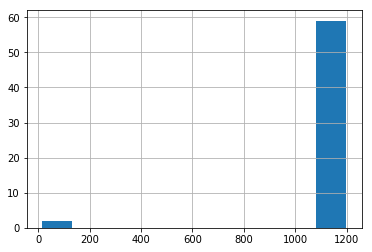

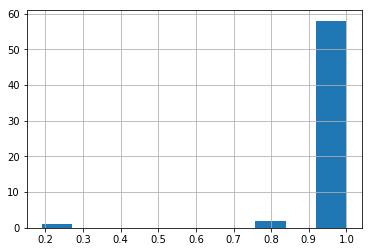

In [11]:
print(f'''Track Times: Mean {df['all', 'Total time (sec)'].mean()}, Minimum {df['all', 'Total time (sec)'].min()}, Maximum {df['all', 'Total time (sec)'].max()}, Count {df['all', 'Total time (sec)'].count()}''')
print(f'''Valid Datapoints: Mean {df['all', '%Valid datapoints'].mean()}, Minimum {df['all', '%Valid datapoints'].min()}, Maximum {df['all', '%Valid datapoints'].max()}, Count {df['all', '%Valid datapoints'].count()}''')

df['all', 'Total time (sec)'].hist()
plt.show()

df['all', '%Valid datapoints'].hist()
plt.show()

## Cleaning: Removing Tracks that Terminated Early or had Poor Tracking
Need to work on something a bit less indiscriminate for initial removal.

Raw Track Number: 61
Modified Track Number: 59 (following removal of tracks less than 75% the length of the experiment mean)
Modified Track Number: 56 (following removal for poor tracking set at less than 0.85% valid datapoints)


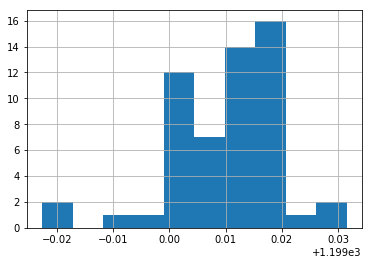

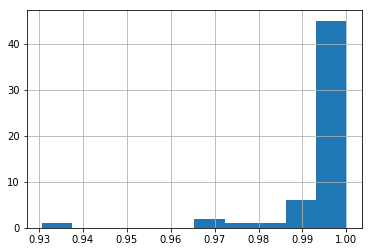

In [12]:
print(f'Raw Track Number: {df.shape[0]}')
df = df.drop(df[df['all', 'Total time (sec)'] < (df['all', 'Total time (sec)'].mean())* .75].index) # drops rows if any data is missing, this will remove early termination tracks
print(f'Modified Track Number: {df.shape[0]} (following removal of tracks less than 75% the length of the experiment mean)')
df = df.drop(df[df['all', '%Valid datapoints'] < acquisitionlevel].index)
print(f'Modified Track Number: {df.shape[0]} (following removal for poor tracking set at less than {acquisitionlevel}% valid datapoints)')

df['all', 'Total time (sec)'].hist()
plt.show()

df['all', '%Valid datapoints'].hist()
plt.show()

## Cleaning: Checking Randomization of Trigger Condition

In [13]:
print(f'Trigger Conditions: {df.trigger.unique()}')
print()

from scipy.stats import ttest_ind

# performs welch's t-test (does not assume equal variances) on all floats and prints any that are signficantly different as a function of trigger
for i in df.select_dtypes(include=['float64']).columns:
    ttest_result = ttest_ind(df[df.trigger == df.trigger.unique()[0]][i], df[df.trigger == df.trigger.unique()[1]][i], equal_var=False, nan_policy='omit')
    
    if ttest_result.pvalue < .05:
        print(f'Welchs T-Test shows {i} is significantly different as a function of trigger condition, p = {ttest_result.pvalue}')
        print(f'{i} Trigger Condition 1 Mean: {df[df.trigger == df.trigger.unique()[0]][i].mean()}')
        print(f'{i} Trigger Condition 2 Mean: {df[df.trigger == df.trigger.unique()[1]][i].mean()}')
        print()

Trigger Conditions: ['xpos > 0.50' 'xpos < 0.50']

Welchs T-Test shows ('all', 'Avg. x coordinate') is significantly different as a function of trigger condition, p = 5.758621024223674e-13
('all', 'Avg. x coordinate') Trigger Condition 1 Mean: 0.3831662411636712
('all', 'Avg. x coordinate') Trigger Condition 2 Mean: 0.6323015952527327

Welchs T-Test shows ('phase 1', '#Valid') is significantly different as a function of trigger condition, p = 0.02924188262768202
('phase 1', '#Valid') Trigger Condition 1 Mean: 2987.344827586207
('phase 1', '#Valid') Trigger Condition 2 Mean: 2979.6296296296296

Welchs T-Test shows ('phase 1', '%Valid datapoints') is significantly different as a function of trigger condition, p = 0.02100518592287035
('phase 1', '%Valid datapoints') Trigger Condition 1 Mean: 0.9993190997445439
('phase 1', '%Valid datapoints') Trigger Condition 2 Mean: 0.9965935172209546

Welchs T-Test shows ('phase 1', 'Valid time (sec)') is significantly different as a function of trigge

## Cleaning: Checking for Box Variations
to do. 

## Analysis/Viz

In [14]:
testdata = {}
i = ('all', 'Trigger frequency (per min)')
for box in df.box.unique():
    testdata[box] = df[df['box'] == box][i].values.tolist()

    

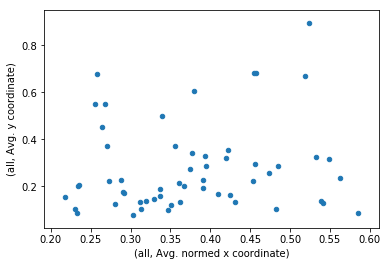

In [15]:
df.plot(kind="scatter", x=('all', 'Avg. normed x coordinate'), y=('all', 'Avg. y coordinate'))

/share/apps/share/jupyter_env/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


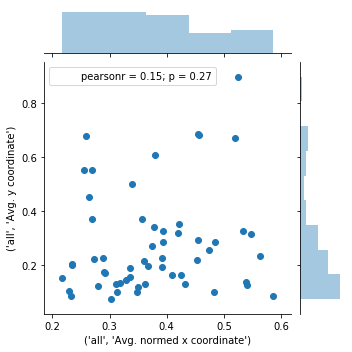

In [16]:
# We can also use the seaborn library to make a similar plot
# A seaborn jointplot shows bivariate scatterplots and univariate histograms in the same figure
seaborn.jointplot(x=('all', 'Avg. normed x coordinate'), y=('all', 'Avg. y coordinate'), data=df, size=5)

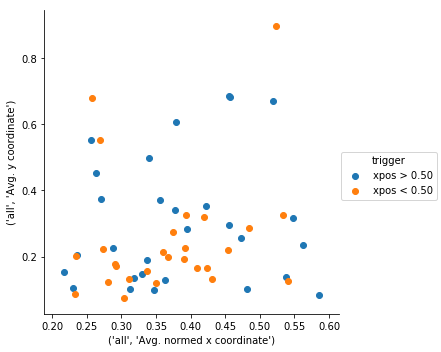

In [17]:
# x=('all', 'Avg. normed x coordinate'), y=('all', 'Avg. y coordinate')

# One piece of information missing in the plots above is what species each plant is
# We'll use seaborn's FacetGrid to color the scatterplot by species
seaborn.FacetGrid(df, hue="trigger", size=5) \
   .map(plt.scatter, ('all', 'Avg. normed x coordinate'), ('all', 'Avg. y coordinate')) \
   .add_legend()

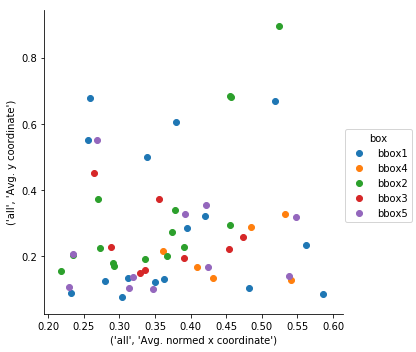

In [18]:
seaborn.FacetGrid(df, hue="box", size=5) \
   .map(plt.scatter, ('all', 'Avg. normed x coordinate'), ('all', 'Avg. y coordinate')) \
   .add_legend()

In [19]:
# def collapse_columns(df): # from https://stackoverflow.com/questions/37087020/collapse-a-pandas-multiindex
#     df = df.copy()
#     if isinstance(df.columns, pd.MultiIndex):
#         df.columns = df.columns.to_series().apply(lambda x: "".join(x))
#     return df

# df = collapse_columns(df)
# df.columns[25]

In [37]:
df2 = df.copy()

for c in range(0,len(df2.columns)-1):
    if isinstance(df2.columns[c], pd.MultiIndex):
        print(c)
        #     df2.columns.to_series().str.join('-')

df2.columns

#maybe collapse multi-index from just the get stats frame?

Index([                                          'phases',
                                             'controller',
                                                'trigger',
                                               'stimulus',
                                                    'box',
                                                   'file',
                                                  'track',
                                             'phase1time',
                                             'phase1stim',
                                             'phase2time',
       ...
                 'phase3-tme to 1st trigger frm ph start',
             'phase3-tme to 1st trigger frm prev trigger',
           'phase3-tme to 1st trigger_plus1 frm ph start',
       'phase3-tme to 1st trigger_plus1 frm prev trigger',
           'phase3-tme to 1st trigger_plus2 frm ph start',
       'phase3-tme to 1st trigger_plus2 frm prev trigger',
           'phase3-tme to 1st trigger_plus3 f

In [36]:
range(0,len(df2.columns))

range(0, 118)

In [21]:
# Now that we've covered seaborn, let's go back to some of the ones we can make with Pandas
# We can quickly make a boxplot with Pandas on each feature split out by species


df.boxplot(by="box", figsize=(12, 6), column=''/('all', 'Avg. y speed (?/sec)/')'')

SyntaxError: invalid syntax (<ipython-input-21-7ac701a69394>, line 5)

In [ ]:
df.boxplot(column=('all', '%Valid datapoints'))
plt.show()

In [ ]:
plotter = TrackPlotter(processor)
plotter.plot_heatmap(plot_type='per-phase')

In [ ]:
# adapted from http://pythonpsychologist.tumblr.com/post/139246503057/repeated-measures-anova-using-python

import pandas as pd
import numpy as np
from scipy import stats

def calc_grandmean(data, columns):
   """
   Takes a pandas dataframe and calculates the grand mean
   data = dataframe
   columns = list of column names with the response variables
   """
   gm = np.mean(data[columns].mean())
   return gm

##For createing example data
X1 = [6,4,5,1,0,2]
X2 = [8,5,5,2,1,0]
X3 = [10,6,5,3,2,4]

dftemp = pd.DataFrame({'Subid':range(1, len(X1)+1), 'X1':X1, 'X2':X2, 'X3':X3})

#Grand mean 
grand_mean = calc_grandmean(dftemp, ['X1', 'X2', 'X3'])
dftemp['Submean'] = dftemp[['X1', 'X2', 'X3']].mean(axis=1)
column_means = dftemp[['X1', 'X2', 'X3']].mean(axis=0)

n = len(dftemp['Subid'])
k = len(['X1', 'X2', 'X3'])
#Degree of Freedom
ncells = dftemp[['X1','X2','X3']].size

dftotal = ncells - 1  #df total variance
dfbw = 3 - 1  #df between treatments variance
dfsbj = len(dftemp['Subid']) - 1   #df between subject variance
dfw = dftotal - dfbw   #df within treatments variance
dferror = dfw - dfsbj  #df error variance
               
SSbetween = sum(n*[(m - grand_mean)**2 for m in column_means])
               
SSwithin = sum(sum([(dftemp[col] - column_means[i])**2 for i, col in enumerate(dftemp[['X1', 'X2', 'X3']])]))
                                   
SSsubject = sum(k*[(m -grand_mean)**2 for m in dftemp['Submean']])
SSerror = SSwithin - SSsubject
SStotal = SSbetween + SSwithin

#MSbetween
msbetween = SSbetween/dfbw

#MSerror
mserror = SSerror/dferror

#F-statistic
F = msbetween/mserror

alpha = 0.05

p_value = stats.f.sf(F, 2, dferror)

p_value